<a href="https://colab.research.google.com/github/martabarbosa1/P5-Forecasting/blob/main/Forecast/Forecast_airport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import plotly.express as px

from sklearn.metrics import mean_squared_error

### Load the Datasets
#originalyy downloaded from https://www.kaggle.com/datasets/sherrytp/airline-delay-analy
df2016 = pd.read_csv('https://raw.githubusercontent.com/Frans-Grau/Datasets/main/P5%20-%20Datasets/df2016.csv')
df2017 = pd.read_csv('https://raw.githubusercontent.com/Frans-Grau/Datasets/main/P5%20-%20Datasets/df2017.csv')
df2018 = pd.read_csv('https://raw.githubusercontent.com/Frans-Grau/Datasets/main/P5%20-%20Datasets/df2018.csv')

### Quick preprocessing
df_all = pd.concat([df2016,df2017,df2018], ignore_index = True, axis = 0)
df_all.drop(['Unnamed: 0','CANCELLED','DIVERTED'], axis=1, inplace= True)
df_all.dropna(inplace=True)
df_all['FL_DATE'] = pd.to_datetime(df_all['FL_DATE'])
df_all['AIRLINE'] = df_all['OP_CARRIER'].apply(lambda x: 'Delta Airlines' if x == 'DL' else 'Southwest Airlines' if x=='WN' else 'American Airlines' if x=='AA'
else 'JetBlue Airways' if x=='B6' else 'SkyWest Airlines' if x=='OO' else 'Atlantic Southeast Airlines' if x == 'EV' else 'United Airlines' if x == 'UA'
else 'Pinnacle Airlines' if x == '9E' else 'Spirit Airlines' if x== 'NK' else 'Alaska Airlines' if x == 'AS' else 'Virgin America' if x == 'VX' else 'Frontier' if x =='F9'
else 'Republic Airlines' if x == 'YX'else 'Hawaiian Airlines' if x == 'HA' else 'Envoy Air' if x == 'MQ' else 'Air Shuttle' if x == 'YV' else 'Allegiant Air' if x=='G4'
else 'Comair')
df_all.head()

#create the time series df with mean and std
df_delay= df_all.groupby('FL_DATE')['DEP_DELAY'].mean().reset_index()
df_delay = df_delay.sort_values('FL_DATE').set_index('FL_DATE')
df_delay_std = df_all.groupby('FL_DATE')['DEP_DELAY'].std().reset_index()
df_delay_std = df_delay_std.sort_values('FL_DATE').set_index('FL_DATE')

In [ ]:
#arima model
from statsmodels.tsa.arima.model import ARIMA
allx = list(range(1, 274))
allx.reverse()

def forecastx(x):
    test_set = df_delay.tail(x)
    train_set = df_delay.head(int(df_delay.shape[0]-test_set.shape[0]))
    arima_model = ARIMA(train_set['DEP_DELAY'], order=(2,0,1), freq = 'D')
    arima_model_fit = arima_model.fit()
    # arima_model_fit.forecast()
    # forecast = arima_model_fit.forecast()
    # return forecast
    return arima_model_fit.forecast()

dep_delay_forecast = list(map(forecastx, allx))
dep_delay_forecast

In [ ]:
forecast = pd.Series(dep_delay_forecast)
forecast = pd.concat(dep_delay_forecast)
test_forecast = pd.concat([test_set, forecast], axis = 1)
test_forecast = test_forecast.rename(columns={'DEP_DELAY' : 'Test_set', 0: 'Forecast_ARIMA'})

In [ ]:
mean_squared_error(test_forecast['Test_set'], test_forecast['Forecast_ARIMA'])

In [ ]:
#exp smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

allx = list(range(1, 274))
allx.reverse()

def expsm_forecastx(x):
    test_set = df_delay.tail(x)
    train_set = df_delay.head(int(df_delay.shape[0]-test_set.shape[0]))
    exp_smoothing = ExponentialSmoothing(train_set['DEP_DELAY'])
    exp_smoothing_fit = exp_smoothing.fit(optimized = True)
    exp_smoothing_fit.forecast()
    forecast =  exp_smoothing_fit.forecast()
    return forecast.iloc[0]

dep_delay_forecast_expsm = list(map(expsm_forecastx, allx))

In [ ]:
dep_delay_forecast_expsm = pd.Series(dep_delay_forecast_expsm, name = 'Forecast_Expsm')
test_forecast_new = pd.concat([test_forecast, dep_delay_forecast_expsm], axis = 1)
test_forecast['Forecast_Expsm'] = list(dep_delay_forecast_expsm)

In [ ]:
mean_squared_error(test_forecast['Test_set'], test_forecast['Forecast_Expsm'])

In [ ]:
#plot both
fig = px.line(test_forecast, x = test_forecast.index, y = ['Test_set', 'Forecast_ARIMA', 'Forecast_Expsm']) #, color_discrete_sequence=["#ff97ff"])
fig.show()

In [ ]:
#new values

In [ ]:
#now the code to forecast future events(next quarter)
new_dates = pd.date_range(start="2019-01-01",end="2019-03-31")

In [ ]:
df_new_dates = pd.DataFrame(new_dates)
df_new_dates.rename(columns = {0 : 'FL_DATE'}, inplace = True)

In [ ]:
df_delay.reset_index(inplace = True)

In [ ]:
df_new = pd.concat([df_delay, df_new_dates], axis = 0)

In [ ]:
df_new.set_index('FL_DATE', inplace = True)

In [ ]:
allx = list(range(1, 91))
allx.reverse()

def forecastx(x):
    test_set = df_new.tail(x)
    train_set = df_new.head(int(df_new.shape[0]-test_set.shape[0]))
    arima_model = ARIMA(train_set['DEP_DELAY'], order=(2,0,1), freq = 'D')
    arima_model_fit = arima_model.fit()
    # arima_model_fit.forecast()
    # forecast = arima_model_fit.forecast()
    # return forecast
    return arima_model_fit.forecast()

dep_delay_forecast = list(map(forecastx, allx))
dep_delay_forecast

In [ ]:
df_result_new = pd.DataFrame(dep_delay_forecast_new)
df_result_new = pd.melt(df_result_new).dropna().rename(columns = {'variable' : 'FL_DATE', 'value' : 'DEP_DELAY'})
df_final = pd.concat([df_delay,df_result_new ], axis=0)
df_final = df_final.set_index('FL_DATE')

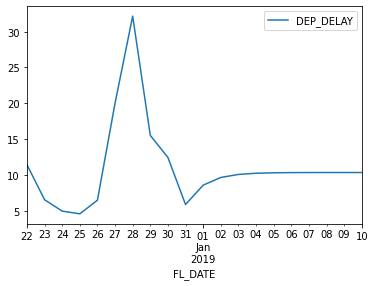

In [ ]:
df_final.iloc[-100 : -80].plot()